# This spread sheet uses surface temperaturue measurements along with Other met and canopy variables and estimates of Rn G to give estimates of ET and compares with measurements

In [13]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates
import MathsUtilities as MUte

## Bring in data

### Bring in the cover Data

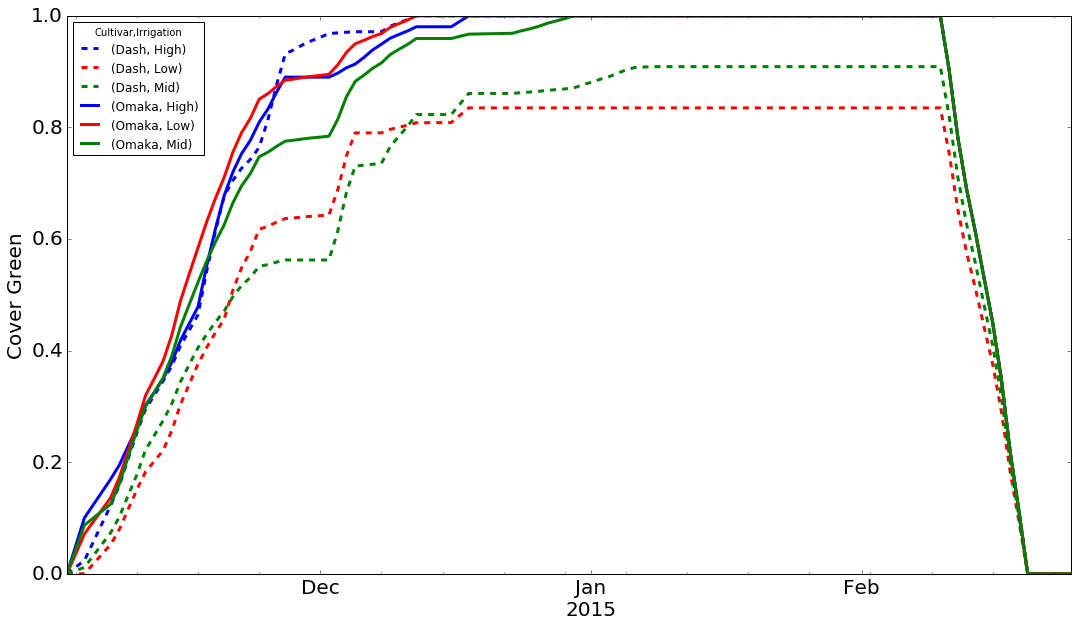

In [14]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

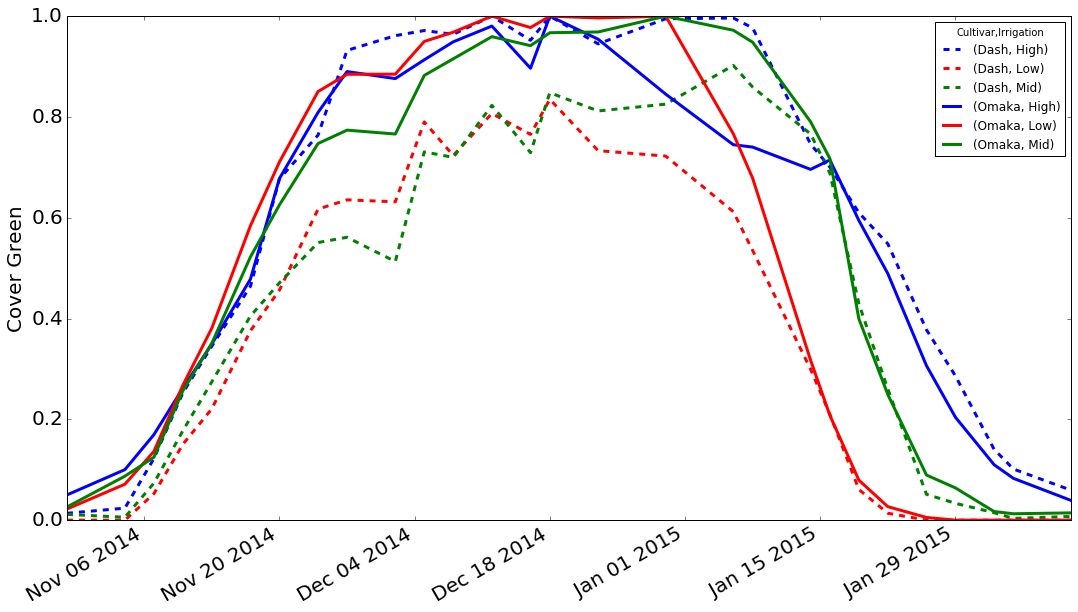

In [15]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

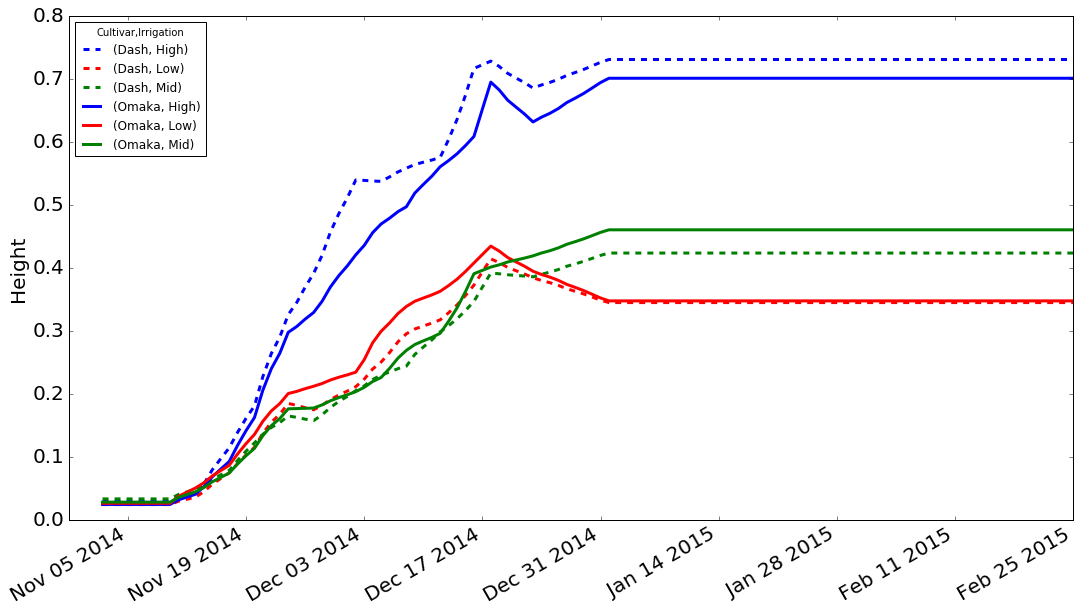

In [16]:
HeightData = pd.read_pickle('.\DataFrames\HeightEstimated.pkl')
HeightData.sort_index(axis=1,inplace=True)
HeightData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Height', fontsize = 20)

## Bring in the Energy Balance Data

In [17]:
EstRn = pd.read_pickle('.\DataFrames\EstNetRadiation.pkl')
EstG= pd.read_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')
HourlyWateruse = pd.read_pickle('.\DataFrames\HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
TnRData.index.name='Date'
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
TsULTa = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')
ECT = '2014-11-08 00:00:00'
LCT = '2015-02-11 00:00:00'

Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1013 #Heat capacity of air Joule/kg/oC
#D=1200
D0 = 4000
T0 = 6
E1 = -0.00015
E0 = -0.0005
E = -0.0005
C1 = 1.2
C0 = 2
CB = 0.6
##Contract dataframes down to common index size
TnRData = TnRData.ix[ECT:LCT,:]

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

## Do some processing and cleaning

In [18]:
#Create a list of time to exclude where data was missing or irrigation was applied
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
IrrigationDates = ['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14']

ExclusionDates = IrrigationDates
for Date in NoMeasurementDates:
    ExclusionDates.append(Date)

#Exclude data from Temperature and radiation dataframe
ExclusionDateTimes5 = []
for Date in ExclusionDates:
    ExclusionDateTimes5 += pd.date_range(Date,periods=288,freq='5T')
TnRData = TnRData.ix[~TnRData.index.isin(ExclusionDateTimes5)]

# Make an index of all daylight hours in trial
HourlyTnRDataSum = TnRData.resample('h').sum()
HourlyTnRDataMean = TnRData.resample('h').mean()
DaylightIndex = HourlyTnRDataSum.ix[:,'IncomingRadnMJ'].where(HourlyTnRDataSum.ix[:,'IncomingRadnMJ']>0.02)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.to_datetime()

# Make day time means and sums for temperature and radiation data
DayTimeTnRDataMean = HourlyTnRDataMean.ix[DaylightIndex].resample('d').mean()
DayTimeTnRDataSum = HourlyTnRDataSum.ix[DaylightIndex].resample('d').sum()

# Make daily (day time) ET dataframe from hourly data excluding dark periods
ET = HourlyWateruse.ix[DaylightIndex].resample('d').sum()
ET = ET.ix[~ET.index.isin(ExclusionDates)]
ET = ET*-1
ET.index.name = 'Date'
ET.columns = ET.columns.swaplevel('Irrigation','Cultivar')

#Exclude non measurement and irrigation dates from Rn and G data frames
EstRn = EstRn.ix[~EstRn.index.isin(ExclusionDates, level=3)]
EstG = EstG.ix[~EstG.index.isin(ExclusionDates)]

#Exclude data from Surface Temperature upper limit dataframe and make daily mean
TsULTa = TsULTa.ix[~TsULTa.index.isin(ExclusionDateTimes5)]
HourlyTsULTa = TsULTa.resample('h').mean()
DayTimeTsULTaMean = TsULTa.ix[DaylightIndex].resample('d').mean()

In [19]:
def makeSeries(Var,Frame):
    SSeries= Frame.ix[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [20]:
#Start off data frame with net radiation data W/m2
EstRn.name = 'EstRn'
EstEnergyBalance = pd.DataFrame(EstRn)

#Make soil heat flux data long and join into energy balance data frame
EstG.index.name='Date'
EstGLong = EstG.unstack()
EstGLong.name = 'EstG'
EstEnergyBalance = EstEnergyBalance.join(EstGLong)

#Make surface temperature data long and join into energy balance data frame
TsTa = np.subtract(DayTimeTnRDataMean.ix[:,'IR_SurfaceTemp'] , DayTimeTnRDataMean.ix[:,'AirTemperature'])
TsTaLong = TsTa.unstack()
TsTaLong.name = 'Ts-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsTaLong)

#Make surface temperature limit data long and join into energy balance data frame
DayTimeTsULTaMean.index.name = 'Date'
TsULTaLong = DayTimeTsULTaMean.unstack()
TsULTaLong.name = 'TsUL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsULTaLong)

#Duplicate Experiment level met data across all treatments and join into energy balance data frame
DateSet = EstEnergyBalance.ix[('Dash','Low','1'),:].index
TnRDataLong = DayTimeTnRDataMean.ix[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)
VPSeries = makeSeries('VP',TnRDataLong)
for plot in PlotList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    EstEnergyBalance.ix[plot,'lamda'] = LamdaSeries.values
    EstEnergyBalance.ix[plot,'Ta'] = tempSeries.values
    EstEnergyBalance.ix[plot,'u'] = windSeries.values
    EstEnergyBalance.ix[plot,'q'] = qSeries.values
    EstEnergyBalance.ix[plot,'VPD'] = VPDSeries.values
    EstEnergyBalance.ix[plot,'Ea'] = VPSeries.values
    EstEnergyBalance.ix[plot,'PET'] = DayTimePET[EstEnergyBalance.ix[plot,'q'].index].values

#Join cover and green cover data into the data frame
EstEnergyBalance.ix[:,'Cover'] = CoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'GreenCover'] = GreenCoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'Height'] = HeightData.ix[DateSet].bfill().unstack()
    
#Calculate some other values    
EstEnergyBalance.ix[:,'qCp'] = EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'uVPD'] = EstEnergyBalance.ix[:,'u'] * EstEnergyBalance.ix[:,'VPD']
EstEnergyBalance.ix[:,'Ts-TaqCp'] = EstEnergyBalance.ix[:,'Ts-Ta'] * EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'EstRn-EstG'] = EstEnergyBalance.ix[:,'EstRn'] - EstEnergyBalance.ix[:,'EstG']

EstEnergyBalance.ix[:,'Ts'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'Ts-Ta']
EstEnergyBalance.ix[:,'To'] = EstEnergyBalance.ix[:,'Ts']  + 0 + EstEnergyBalance.ix[:,'VPD'] * 1
EstEnergyBalance.ix[:,'To-Ta'] =  EstEnergyBalance.ix[:,'To'] -  EstEnergyBalance.ix[:,'Ta'] 
EstEnergyBalance.ix[:,'TsUL'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'TsUL-Ta']
EstEnergyBalance.ix[:,'ToUL'] = EstEnergyBalance.ix[:,'TsUL'] + 0 +  EstEnergyBalance.ix[:,'VPD'] * 1
EstEnergyBalance.ix[:,'ToUL-Ta'] = EstEnergyBalance.ix[:,'ToUL'] - EstEnergyBalance.ix[:,'Ta']
EstEnergyBalance.ix[:,'(To-Ta)/(ToUL-Ta)'] = EstEnergyBalance.ix[:,'To-Ta']/EstEnergyBalance.ix[:,'ToUL-Ta']
EstEnergyBalance.ix[:,'(To-Ta)qCp'] = EstEnergyBalance.ix[:,'To-Ta'] * EstEnergyBalance.ix[:,'qCp']

IntIndex = range(EstEnergyBalance.index.size)
EstEnergyBalance.ix[:,'EqEvap'] = [et.Priestly_TaylorEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],1,'net') for x in IntIndex]
EstEnergyBalance.ix[:,'PenEvap'] = [et.PenmanEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],EstEnergyBalance.ix[x,'u'],EstEnergyBalance.ix[x,'Ea'],'net') for x in range(EstEnergyBalance.index.size)]
EstEnergyBalance.ix[:,'PotA'] = EstEnergyBalance.ix[:,'PenEvap']/EstEnergyBalance.ix[:,'EqEvap']
EstEnergyBalance.ix[:,'PotB'] = [et.PotB(EstEnergyBalance.ix[x,'Ta'],EstEnergyBalance.ix[x,'PotA']) for x in IntIndex] 

#Make water use data long and join into energy balance dataset
ETLong = ET.unstack()
ETLong.name = 'ET'
EstEnergyBalance = EstEnergyBalance.join(ETLong)

#Find maximum daily values for ET and To across the experiment to use as potentials
PotVars = ['ET','To']
PotVarFilter = EstEnergyBalance.columns.isin(PotVars)
TreatMeans = EstEnergyBalance.ix[:,PotVarFilter].groupby(level = ['Cultivar','Irrigation','Date']).mean()
for plot in PlotList:
    EstEnergyBalance.ix[plot,'PotET'] = TreatMeans.ix[:,'ET'].groupby(level='Date').max().values
    EstEnergyBalance.ix[plot,'PotTo'] = TreatMeans.ix[:,'To'].groupby(level='Date').min().values

#Calculate evapotranspiration
#EstEnergyBalance.ix[:,'PotEo'] = [PotEo(1.23,EstEnergyBalance.ix[x,'PotTo'],EstEnergyBalance.ix[x,'Ta'],EstEnergyBalance.ix[x,'Ea']) for x in IntIndex]
#EstEnergyBalance.ix[:,'Eo'] = [Eo(EstEnergyBalance.ix[x,'PotEo'],EstEnergyBalance.ix[x,'PotTo'],EstEnergyBalance.ix[x,'To']) for x in IntIndex]
#EstEnergyBalance.ix[:,'B'] = [B(EstEnergyBalance.ix[x,'PotB'],EstEnergyBalance.ix[x,'PotTo'],EstEnergyBalance.ix[x,'To'],EstEnergyBalance.ix[x,'Ta'],EstEnergyBalance.ix[x,'PotEo'],EstEnergyBalance.ix[x,'Eo'],EstEnergyBalance.ix[x,'Ea']) for x in IntIndex]
#EstEnergyBalance.ix[:,'EstET'] = [JamiesonET(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'B'],EstEnergyBalance.ix[x,'lamda']) for x in IntIndex]
#EstEnergyBalance.ix[:,'EstET'] = [et.Priestly_TaylorEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],1.26,'net') for x in IntIndex]
EstEnergyBalance.ix[:,'A'] = EstEnergyBalance.ix[:,'ET']/EstEnergyBalance.ix[:,'EqEvap']
EstEnergyBalance.ix[:,'FitA'] = [6/(EstEnergyBalance.ix[x,'To-Ta']+4) for x in IntIndex]
EstEnergyBalance.ix[:,'Aresid'] = EstEnergyBalance.ix[:,'A'] - EstEnergyBalance.ix[:,'FitA']

#Calculate residual
#EstEnergyBalance.ix[:,'ResidualET'] = EstEnergyBalance.ix[:,'ET'] - EstEnergyBalance.ix[:,'EstET']

#make a dataframe with treatment means
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()



In [10]:
EstEnergyBalance.ix[:,'PotTo-Ta'] = EstEnergyBalance.ix[:,'PotTo'] - EstEnergyBalance.ix[:,'Ta']
EstEnergyBalance.ix[:,'Eo-Ea'] = EstEnergyBalance.ix[:,'Eo'] - EstEnergyBalance.ix[:,'Ea']


KeyError: 'Eo'

In [ ]:
def PotEo(Alpha, PotTo, Ta, Ea):
    s = et.saturated_vapor_pressure_slope(Ta)
    gamma = et.gama(Ta)
    _ret = Ea + ((Alpha * s * gamma)/(gamma + s * (1-gamma))) * (PotTo - Ta)
    return _ret

In [ ]:
def Eo(PotEo,PotTo,To):
    gamma = et.gama(To)
    _ret = PotEo - gamma * (To-PotTo)
    return _ret

In [ ]:
def B(PotB,PotTo,To,Ta,PotEo,Eo,Ea):
    #_ret = PotB * (((To-Ta)*(PotEo-Ea))/((PotTo-Ta)*(Eo-Ea)))
    _ret = (PotEo-Ea)/(Eo-Ea)
    return _ret

In [ ]:
def JamiesonET(Rn_G,Beta,lamda):
    _ret = Rn_G / (1+Beta)
    _ret/lamda
    return _ret

In [ ]:
EstEnergyBalance.ix[:,'PrTE'] = [et.Priestly_TaylorEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],1.26,'net') for x in IntIndex]

In [ ]:
Cultivar = 'Omaka'
Irrig = 'High'
JamPE = EstEnergyBalance.ix[(Cultivar,Irrig),'EstET'].groupby(level='Date').mean().dropna()

ActualET = EstEnergyBalance.ix[(Cultivar,Irrig),'ET'].groupby(level='Date').mean().dropna()
plt.plot(ActualET.ix['2014-11-16':'2015-01-15'].cumsum(),JamPE.ix['2014-11-16':'2015-01-15'].cumsum(),'o')
plt.plot([0,300],[0,300])

In [12]:
Graph = plt.figure(figsize=(18,10))
Cultivar = 'Omaka'
Irrig = 'Low'
Vars = ['HSlop']
for var in Vars:
    Data = EstEnergyBalance.ix[(Cultivar,Irrig),var].groupby(level='Date').mean().dropna()
    plt.plot(Data,label = var)
plt.legend()
#plt.ylim(-1,3)

KeyError: 'HSlop'

In [74]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'A']
        X = EBMeans.ix[(cul,irr),'GreenCover']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1

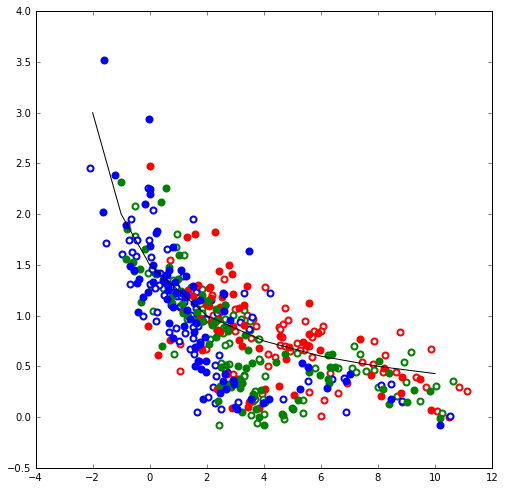

In [84]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0
        Y = EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'To-Ta'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
y = np.divide(6,np.add(x,4))
plt.plot(x,y)

In [88]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0
        Y = EBMeans.ix[(cul,irr),'Aresid'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'GreenCover'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [0,0.5,1]   
y = [-.7,0,0]
plt.plot(x,y)

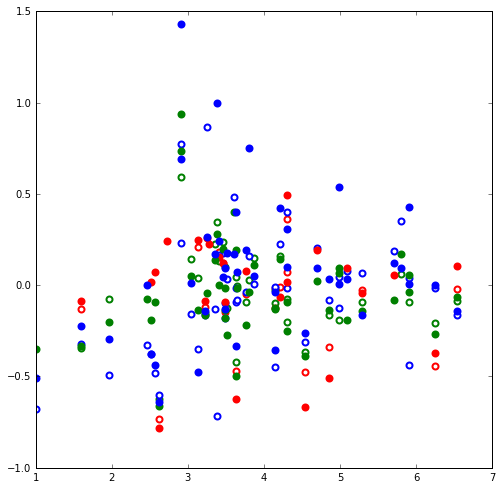

In [93]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.7
        Y = EBMeans.ix[(cul,irr),'Aresid'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'u'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
# x = [0,0.7,1]   
# y = [-.8,0,0]
# plt.plot(x,y)

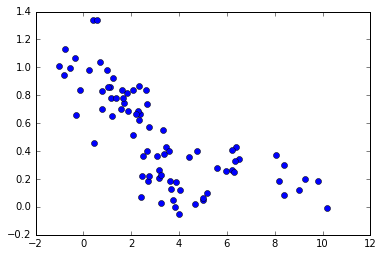

In [72]:
RelativeAlpha = EstEnergyBalance.ix[(Cultivar,Irrig),'A'].groupby(level='Date').mean()/EstEnergyBalance.ix[(Cultivar,Irrig),'PotA'].groupby(level='Date').mean()
Cover = EstEnergyBalance.ix[(Cultivar,Irrig),'To-Ta'].groupby(level='Date').mean()
plt.plot(Cover,RelativeAlpha,'o')

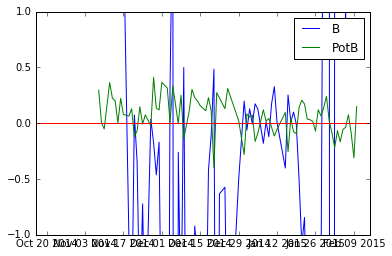

In [165]:
Cultivar = 'Omaka'
Irrig = 'Low'
Vars = ['B','PotB']
for var in Vars:
    Data = EstEnergyBalance.ix[(Cultivar,Irrig),var].groupby(level='Date').mean().dropna()
    plt.plot(Data,label = var)
plt.legend()
plt.ylim(-1,1)
plt.plot(['2014-10-16','2015-02-15'],[0,0])

(-2, 2)

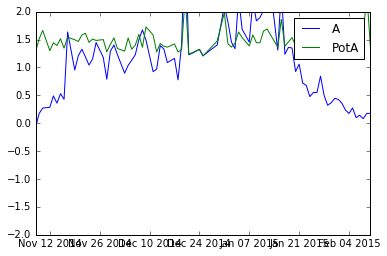

In [116]:
Cultivar = 'Omaka'
Irrig = 'High'
Vars = ['A','PotA']
for var in Vars:
    Data = EstEnergyBalance.ix[(Cultivar,Irrig),var].groupby(level='Date').mean().dropna()
    plt.plot(Data,label = var)
plt.legend()
plt.ylim(-2,2)

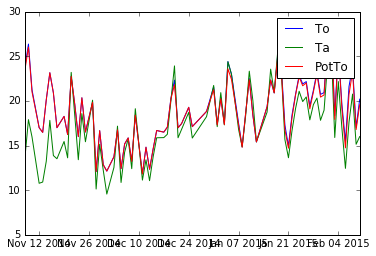

In [151]:
Cultivar = 'Omaka'
Irrig = 'High'
Vars = ['To','Ta','PotTo']
for var in Vars:
    Data = EstEnergyBalance.ix[(Cultivar,Irrig),var].groupby(level='Date').mean().dropna()
    plt.plot(Data,label = var)
plt.legend()

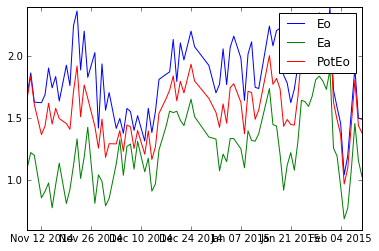

In [29]:
Cultivar = 'Omaka'
Irrig = 'High'
Vars = ['Eo','Ea','PotEo']
for var in Vars:
    Data = EstEnergyBalance.ix[(Cultivar,Irrig),var].groupby(level='Date').mean().dropna()
    plt.plot(Data,label = var)
plt.legend()

2

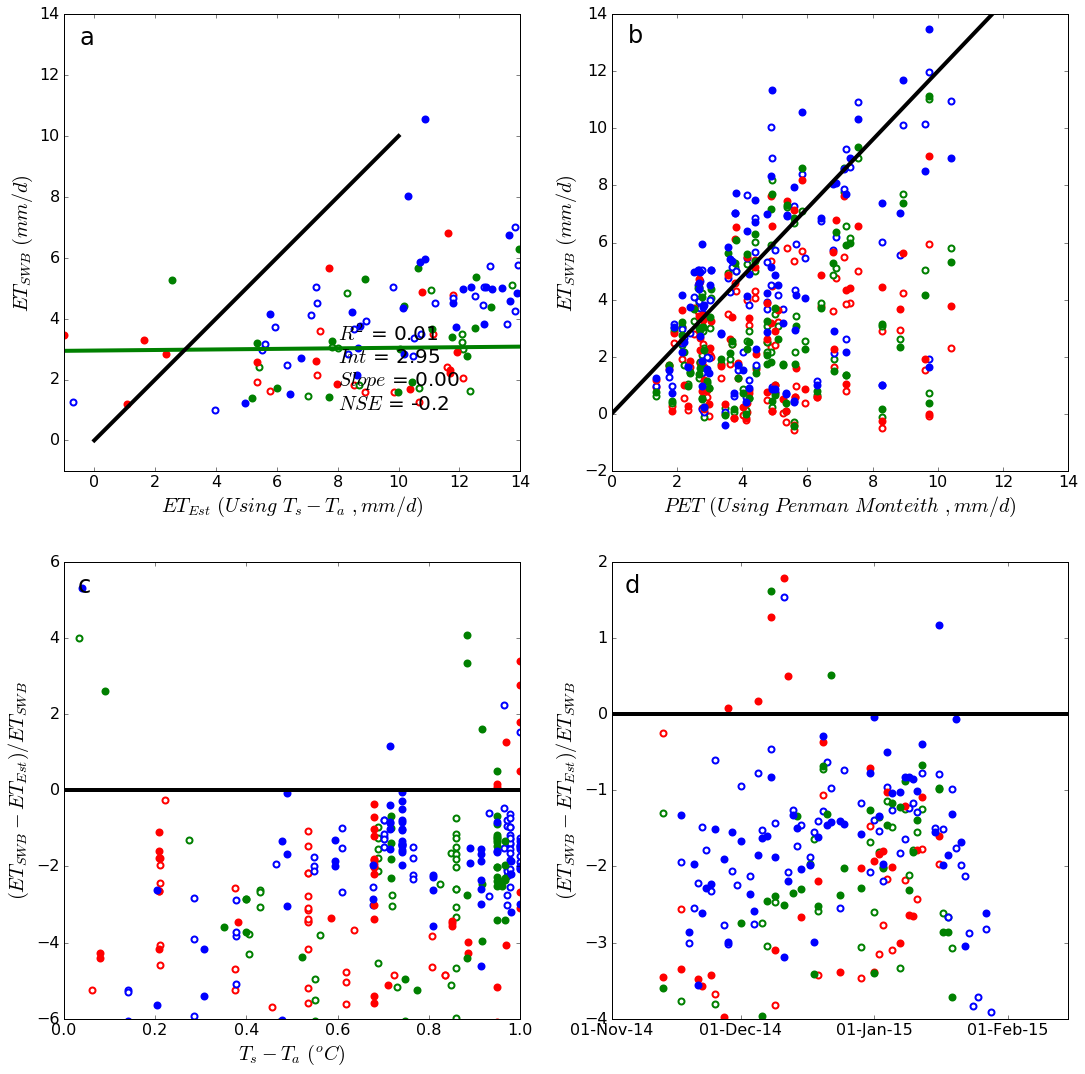

In [148]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'ET'].ix['2014-11-16':'2015-01-15']
        X = EBMeans.ix[(cul,irr),'EstET'].ix['2014-11-16':'2015-01-15']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
#Make a binary filter to exclude High and Low reatments
ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
X = EBMeans.ix[ValidationFilter,'EstET'] 
Y = EBMeans.ix[ValidationFilter,'ET']
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
plt.plot(Xs,Ys,'-', linewidth = 4, color='g')
plt.plot([0,10],[0,10],'-', linewidth = 4, color='k')
fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
    + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
    + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
plt.text(8,1.,fitR2,fontsize=20)        
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
plt.xlabel(r'$ET_{Est}$ $(Using$ $T_s-T_a$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.text(-0.5,13,'a',fontsize=24)
plt.xlim(-1,14)
plt.ylim(-1,14)



fig = Comparison.add_subplot(2,2,2)
culpos = 0
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'ET']
        #X = DayTimePET.ix[Y.index]
        X = EBMeans.ix[(cul,irr),'PET']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
plt.plot([0,12],[0,14.4],'-', linewidth = 4, color='k')
plt.xlabel('$PET$ $(Using$ $Penman$ $Monteith$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.ylim(-2,14)
plt.text(0.5,13,'b',fontsize=24)
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
#plt.legend(['Low Dash','Mid Dash','High Dash','Low Omaka','Mid Omaka','High Omaka'],loc=[-1.25,1.05],ncol=6,fontsize=18)
#plt.text(-8,16.5,'Irrigation level and cultivar treatments',fontsize=24)
plt.xlim(0,14)


fig = Comparison.add_subplot(2,2,3)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0 
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = EstEnergyBalance.ix[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean()
        plt.plot(xData,yData/yObs, 'o',  mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlabel('$T_s-T_a$ $(^oC)$',fontsize=20)
plt.tick_params(labelsize = 16)
plt.text(0.03,5.2,'c',fontsize=24)
plt.ylim(-6,6)
plt.plot([0,1],[0,0],'-', linewidth = 4, color='k')

fig = Comparison.add_subplot(2,2,4)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0  
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = yData.index
        plt.plot(xData,yData/yObs, 'o', mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
    plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlim('2014-11-1','2015-02-15')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=16)
plt.text('2014-11-4',1.6,'d',fontsize=24)
plt.ylim(-4,2)
plt.plot(['2014-11-1','2015-02-15'],[0,0],'-', linewidth = 4, color='k')

In [30]:
EstEnergyBalance.PotET

Cultivar  Irrigation  Block  Date      
Dash      High        1      2014-11-02         NaN
                             2014-11-03         NaN
                             2014-11-04         NaN
                             2014-11-05         NaN
                             2014-11-06         NaN
                             2014-11-07         NaN
                             2014-11-08    0.338135
                             2014-11-09    1.022935
                             2014-11-10    1.186182
                             2014-11-12    0.973735
                             2014-11-13    2.056971
                             2014-11-14    1.761283
                             2014-11-15    2.895342
                             2014-11-16    2.263188
                             2014-11-17    3.755857
                             2014-11-19    4.513133
                             2014-11-20    4.885682
                             2014-11-21    7.045133
                        